In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


##################### LOAD DATA  ###################

from pathlib import Path
import glob


pd_ologbo = pd.read_csv("data/OLOGBO__999.csv", sep=";", header=0)
pd_ologbo = pd_ologbo.drop(pd_ologbo.columns[[0, 1, 2]],axis = 1)
ologbo_data = pd_ologbo.astype(np.float32).values

# #### Monosite
# pd_nasa = pd.read_csv("data/OLOGBO_AllNASA_999.csv", sep=";", header=0)
# pd_nasa = pd_nasa.drop(pd_nasa.columns[[0, 1]],axis = 1)
# nasa_data = pd_nasa.astype(np.float32).values


### Multisite
rootdir = Path('data')
file_list = [f for f in rootdir.glob('**/File*') if f.is_file()]

nasa_data = []
for f in file_list:
    pd_nasa = pd.read_csv(f, sep=",", header=0)
    pd_nasa = pd_nasa.drop(pd_nasa.columns[[0, 1, 2]],axis = 1)
    if len(nasa_data) == 0:
        nasa_data = pd_nasa.astype(np.float32).values
    else:
        nasa_data = np.hstack((nasa_data, pd_nasa.astype(np.float32).values))
print(ologbo_data.shape, nasa_data.shape)

(3158, 9) (3158, 342)


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, SpatialDropout1D,BatchNormalization,Flatten, Dropout, Input, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
import json


def get_samples(col_to_predict, split_proportion=0.7, sample_size=6, pos="mid"):

    missing_rows = np.argwhere(ologbo_data[:,col_to_predict] == -999).flatten()
    sample_array = np.arange(sample_size)

    x = []
    y = []

    for i in range(len(nasa_data) - sample_size):
        local_samples = sample_array + i
        if True not in np.isin(missing_rows, local_samples):
            x.append(nasa_data[local_samples])
            if pos == "mid":
                y.append(ologbo_data[i+int(sample_size/2), col_to_predict]) ## mid value
            else:
                y.append(ologbo_data[i+sample_size-1, col_to_predict]) ## last value

    x = np.array(x)
    y = np.array(y).reshape(-1,1)

    split_index = int(len(y) * split_proportion)

    x_train, x_test = x[0:split_index], x[split_index+1:]
    y_train, y_test = y[0:split_index], y[split_index+1:]

    x_scaler = MinMaxScaler()
    x_train_s = x_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test_s = x_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    y_scaler = MinMaxScaler()
    y_train_s = y_scaler.fit_transform(y_train)
    y_test_s = y_scaler.transform(y_test)

    return x_train, x_test, y_train, y_test, x_train_s, x_test_s, y_train_s, y_test_s, x_scaler, y_scaler


class Auto_Save(Callback):
    best_weights = []
    def __init__(self):
        super(Auto_Save, self).__init__()
        self.best = np.Inf
                
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss, self.best):
            self.best = current_loss            
            Auto_Save.best_weights = self.model.get_weights()
            print("\r", end="")
            print("Best so far >" + str(self.best) + " at epoch: " + str(int(epoch)) + " -- ", end="")
            
    def on_train_end(self, logs=None):
        if self.params['verbose'] == 2:
            print('\nSaved best {0:6.4f}\n'.format(self.best))


def train_model(model, x_train_s, x_test_s, y_train_s, y_test_s, model_name):
    model_file = "results/" + model_name + ".hdf5"
    # mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', mode='min') 
    earlyStopping = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min') 
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=200, verbose=0, min_delta=1e-6, mode='min')

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    model.fit(  x_train_s, y_train_s, 
                epochs=15000, 
                batch_size=4000, 
                shuffle=True, 
                verbose=0,
                callbacks=[reduce_lr_loss, earlyStopping, Auto_Save()],
                validation_data = (x_test_s, y_test_s))

    return model_file, model

def validate_prediction(model_file, model_name, col_name, model, x_test_s, y_test, y_scaler, show=True):
    # model.load_weights(model_file)
    model.set_weights(Auto_Save.best_weights)
    y_predict = model.predict(x_test_s, verbose=0)
    y_predict = y_scaler.inverse_transform(y_predict)
    RMSE = np.sqrt(np.mean((y_test-y_predict)**2))
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    MAPE = mean_absolute_percentage_error(y_test, y_predict)
    R2 = r2_score(y_test, y_predict)

    result_file = open("NASA_benchmark_global.txt", "a")
    result_file.write("-" * 30)
    result_file.write(model_name)
    result_file.write("Model for column " + col_name + " with serie of size " + str(x_test_s.shape[1]) + "\n")
    result_file.write("RMSE: " + str(RMSE) + "\n")
    result_file.write("MAE: " + str(MAE) + "\n")
    result_file.write("MSE: " + str(MSE) + "\n")
    result_file.write("MAPE: " + str(MAPE) + "\n")
    result_file.write("R²: " + str(R2) + "\n")
    result_file.close()

    plt.plot(y_test)
    plt.plot(y_predict)
    # plt.ylim([15, 35])
    plt.rcParams["figure.figsize"] = (20,6)
    plt.xlabel("Days")
    plt.ylabel(col_name)
    plt.legend(["Ologbo", "Predicted"])
    plt.title(model_file)
    plt.savefig('results/'+ model_name +'.png')
    plt.margins(0.05, 0.15)
    if show is True:
        plt.show()
    else:
        plt.close()

    return RMSE, MAE, MSE, MAPE, R2

In [57]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalAveragePooling1D, SpatialDropout1D,BatchNormalization,Flatten, \
    Dropout, Input, Bidirectional, LSTM, GRU, DepthwiseConv1D, AveragePooling1D, MaxPooling1D, SeparableConv1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras import Model
import tensorflow_addons as tfa
# from tensorflow_addons.layers import MultiHeadAttention

def dense_model(x_train):##4
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    # model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model.summary()
    return model

def LSTM_model(x_train): ##4
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Bidirectional(LSTM(16, activation='relu')))
    # model.add(Bidirectional(LSTM(16))) ## CUDNN
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def GRU_model(x_train): ##4
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Bidirectional(GRU(16)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def Conv_model(x_train): ##12
    kernel_size = min(3,x_train.shape[1])
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Dropout(0.05))
    model.add(Conv1D(filters=8, kernel_size=kernel_size, padding="same"))
    model.add(Conv1D(filters=32, kernel_size=kernel_size, padding="same"))
    model.add(Conv1D(filters=8, kernel_size=kernel_size))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='linear'))
    return model

def Conv_model2(x_train): ##12
    kernel_size = min(3,x_train.shape[1])
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Conv1D(filters=16, kernel_size=kernel_size, padding="same"))
    model.add(LayerNormalization(epsilon=1e-6))
    model.add(Conv1D(filters=64, kernel_size=kernel_size, padding="same"))
    model.add(LayerNormalization(epsilon=1e-6))
    model.add(Conv1D(filters=16, kernel_size=kernel_size))
    model.add(LayerNormalization(epsilon=1e-6))
    model.add(Flatten())
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='linear'))
    return model

def Conv_model3(x_train): ##12
    kernel_size = min(3,x_train.shape[1])
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(DepthwiseConv1D(kernel_size=1, padding="same",depth_multiplier=6, activation='relu'))
    model.add(LayerNormalization(epsilon=1e-6))
    model.add(Conv1D(filters=32, kernel_size=1, padding="same"))
    model.add(LayerNormalization(epsilon=1e-6))
    model.add(Conv1D(filters=8, kernel_size=1))
    model.add(LayerNormalization(epsilon=1e-6))
    model.add(Flatten())
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='linear'))
    return model

def SepConv_model(x_train):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(SeparableConv1D(64, kernel_size=3, depth_multiplier=3, padding="same", activation='relu'))
    model.add(Conv1D(filters=16, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def DepthConv_model(x_train):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(DepthwiseConv1D(kernel_size=3, padding="same",depth_multiplier=3, activation='relu'))
    model.add(DepthwiseConv1D(kernel_size=3, padding="same",depth_multiplier=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=16, kernel_size=3))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

def transformer(
    x_train,
    head_size=32,
    num_heads=4,
    ff_dim=8,
    num_transformer_blocks=2,
    mlp_units=[32],
    dropout=0.05,
    mlp_dropout=0.1,
):
    inputs = Input(shape=x_train.shape[1:])
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)

rd_seed = 163
np.random.seed(rd_seed)
tf.random.set_seed(rd_seed)

split_proportion = 0.7
col_names = ["TMin","TMax","TAverage","HRMin","HRMax","HRAverage","WindSpeed","Rainfall","Rg"]
# ranges = [4,5,6,8,10,12,24]
ranges = [[1,2,3,4,5],[7,9,11,13],[9,13,15,21],[7,9,11,13],[1,2,3,4,5],[1,3,5,7],[9,13,15,21],[5,7,9,11,13],[1,2,3,4,5]]
positions = ["mid"]
# functions = [dense_model, LSTM_model, GRU_model, Conv_model, SepConv_model, DepthConv_model, transformer]
functions = [Conv_model]#, Conv_model2, Conv_model3]
# functions = [Conv_model, DepthConv_model, transformer]


# cols_to_predict = [8]
# for col_to_predict in cols_to_predict:
for col_to_predict in range(len(col_names)):
    results = {}
    col_name = col_names[col_to_predict]
    for sample_size in ranges[col_to_predict]:
        for pos in positions:
            for model_func in functions:
                model_name = "nasa_monosite_col-" + col_name + "_seriesize-" + str(sample_size) + "_model-" + model_func.__name__ + "_" + pos
                x_train, x_test, y_train, y_test, x_train_s, x_test_s, y_train_s, y_test_s, x_scaler, y_scaler = get_samples(col_to_predict, split_proportion, sample_size, pos=pos)
                model = model_func(x_train)
                model_file, model = train_model(model, x_train_s, x_test_s, y_train_s, y_test_s, model_name)
                RMSE, MAE, MSE, MAPE, R2 = validate_prediction(model_file, model_name, col_name, model, x_test_s, y_test, y_scaler, show=False)
                results[model_name] = {"model":model_func.__name__, "column":col_name, "size":str(sample_size),"RMSE":str(RMSE), "R²":str(R2), "MAE":str(MAE), "MSE":str(MSE), "MAPE":str(MAPE)}
                print("*"*5, model_name, len(x_train), RMSE, "*"*5)
    
    results = sorted(results.items(), key=lambda k_v: k_v[1]['RMSE'])
    with open('results_' + col_name + '.json', 'w') as fp:
        json.dump(results, fp, indent=4)

Best so far >0.006526146549731493 at epoch: 1763 --  ***** nasa_multisite_col-TMin_seriesize-1_model-Conv_model_mid 1744 1.0017285 *****
Best so far >0.006687565241008997 at epoch: 2675 --  ***** nasa_multisite_col-TMin_seriesize-1_model-Conv_model2_mid 1744 1.0140414 *****
Best so far >0.006833525840193033 at epoch: 1582 --  ***** nasa_multisite_col-TMin_seriesize-1_model-Conv_model3_mid 1744 1.0250477 *****
Best so far >0.005667560733854771 at epoch: 951 --  ***** nasa_multisite_col-TMin_seriesize-2_model-Conv_model_mid 1725 0.9335116 *****
Best so far >0.006122875027358532 at epoch: 781 --  ***** nasa_multisite_col-TMin_seriesize-2_model-Conv_model2_mid 1725 0.97028506 *****
Best so far >0.006321026477962732 at epoch: 482 --  ***** nasa_multisite_col-TMin_seriesize-2_model-Conv_model3_mid 1725 0.98586047 *****
Best so far >0.005914263892918825 at epoch: 1622 --  ***** nasa_multisite_col-TMin_seriesize-3_model-Conv_model_mid 1708 0.9536128 *****
Best so far >0.005930798128247261 at e

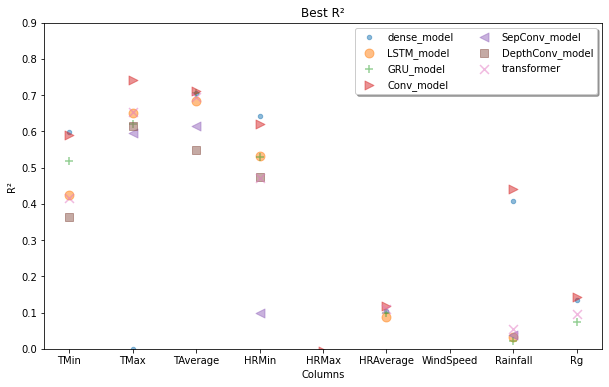

In [50]:
import json

col_names = ["TMin","TMax","TAverage","HRMin","HRMax","HRAverage","WindSpeed","Rainfall","Rg"]
ranges = [3,4,5,9,16]
functions = ["dense_model", "LSTM_model", "GRU_model", "Conv_model", "SepConv_model", "DepthConv_model", "transformer"]
markers = {"dense_model":".", "LSTM_model":"o", "GRU_model":"+", "Conv_model":">", "SepConv_model":"<", "DepthConv_model":"s", "transformer":"x"}
x_axis = np.arange(len(ranges))

metric = "R²" #"RMSE"

global_series = {}
for col in col_names:
    global_series[col] = [0 for _ in functions]

for col_name in col_names:
    json_file = open('results_monosite/results_' + col_name + '.json')
    data = json.load(json_file)
    
    series = {}
    for model_func in functions:
        series[model_func] = [0 for x in ranges]
    for d in data:
        d = d[1]
        # print(d["model"], d["size"], d["RMSE"])
        series[d["model"]][ranges.index(int(d["size"]))] = float(d[metric])
    for i in range(len(functions)):
        global_series[col_name][i] = min(series[functions[i]])

    max_ = max(max(series.values()))
    min_ = min(min(series.values()))

    # plt.rcParams["figure.figsize"] = (5,5)
    # for k,v in series.items():
    #     plt.scatter(x_axis, v, 80, alpha=0.5, marker=markers[k])  

    # plt.xlabel("serie size")
    # plt.ylabel(metric)
    # plt.xticks(x_axis, ranges)
    # plt.legend(list(markers.keys()), loc='upper center', ncol=2, fancybox=True, shadow=True)
    
    # plt.title(col_name + " " + metric)
    # plt.savefig('predictions_'+ col_name + '.png')
    # yr = max_ - min_
    # min_ = min_ - min(min_*0.02, yr*0.02)
    # # max_r = min_r = yr*0.8
    # plt.ylim([min_,max_])
    # plt.show()

plt.rcParams["figure.figsize"] = (10,6)
global_array = np.array(list(global_series.values()))
for i in range(len(functions)):
    # print(i, np.arange(len(col_names)), global_array[:,i], marker=markers[functions[i]])
    plt.scatter(np.arange(len(col_names)), global_array[:,i], 80, alpha=0.5, marker=markers[functions[i]])  
# for k,v in global_series.items():
#     plt.scatter(np.arange(len(col_names)), v, 80, alpha=0.5, marker=markers[functions])  

plt.xlabel("Columns")
plt.ylabel(metric)
plt.xticks(np.arange(len(col_names)), col_names)
plt.legend(list(markers.keys()), loc='upper right', ncol=2, fancybox=True, shadow=True)
plt.title("Best " + metric)
plt.savefig('predictions_global.png')
# yr = max_ - min_
# min_ = min_ - min(min_*0.02, yr*0.02)
# # max_r = min_r = yr*0.8
plt.ylim([0,0.9])
plt.show()